# atumaCup10th でサンプルデータがあったので、それを確認

# import etc

In [1]:
# ライブラリのインストール
!pip install pytorch-tabnet
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText
!rm -rf fastText
!pip install category_encoders

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
     |████████████████████████████████| 68 kB 5.1 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3127063 sha256=5f5c694eef0918d2709bac6e2d8c6a3250e55a3683f08ee49f90b662d6bb2406
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fastText
     |████████████████████████████████| 82 kB 472 kB/s 


In [2]:
import os, warnings, re, datetime, random
from typing import Union, List, Optional
from requests import get
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorsys import rgb_to_hsv

from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import category_encoders as ce
from sklearn.metrics import mean_squared_error

from fasttext import load_model
from gensim.models import word2vec
import hashlib

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_tabnet.pretraining import TabNetPretrainer #事前学習
from pytorch_tabnet.tab_model import TabNetRegressor

tqdm.pandas()
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 300)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 実行前にドライブマウントする
%cd /content/drive/MyDrive/Input/Tabnet/notebook

/content/drive/MyDrive/Input/Tabnet/notebook


In [9]:
# config
NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace('.ipynb', '')
DATA_DIR = '../input' # csvを保存してあるディレクトリ
TARGET_COL = 'likes'
SEED = 0
FOLD = 5

In [11]:
train_raw = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_raw = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
df_raw = pd.concat([train_raw, test_raw], ignore_index=True)

# Preprocess&FeatureEngineering

[初心者講座#2](https://www.guruguru.science/competitions/16/discussions/95b7f8ec-a741-444f-933a-94c33b9e66be/)で紹介されているBlockによる特徴作成をベースにしています。

In [12]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError

In [13]:
def left_join(left, right, on='object_id'):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

## メタ情報

### `object_id`と`name`からなるメタ情報

上記の2列のみからなる以下の各ファイルです。
- hirstorical_person.csv
- material.csv
- object_collection.csv
- technique.csv
- production_place.csv

これらは[Word2Vecによる特徴量化](https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/)を行います。その際、これらのファイル以外の情報（例えば、train.csvやtest.csvの`dating_period`情報など）も一緒に文章の一部と見立ててWord2Vecで処理できる様に、同じ形式のpd.DataFrameを用意しておきます。

#### `object_id` + `name`形式のpd.DataFrameの用意

In [14]:
# 読み込むだけ
historical_person = pd.read_csv(os.path.join(DATA_DIR, 'historical_person.csv'))
material = pd.read_csv(os.path.join(DATA_DIR, 'material.csv'))
object_collection = pd.read_csv(os.path.join(DATA_DIR, 'object_collection.csv'))
technique = pd.read_csv(os.path.join(DATA_DIR, 'technique.csv'))
production_place = pd.read_csv(os.path.join(DATA_DIR, 'production_place.csv'))

# principal_makerから作成
principal_maker = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker.csv'))
principal_maker_occupation = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker_occupation.csv'))
makers = principal_maker[['object_id', 'maker_name']].rename(columns={'maker_name': 'name'})
occupation = principal_maker.merge(principal_maker_occupation, on='id', how='left')[['object_id', 'name']].dropna().reset_index(drop=True)
qualification = principal_maker[['object_id', 'qualification']].rename(columns={'qualification': 'name'}).dropna().reset_index(drop=True)

# df_rawから作成
def get_object_name_df(col):
    return df_raw[['object_id', col]].rename(columns={col: 'name'})

acquisition_method = get_object_name_df('acquisition_method')
period = get_object_name_df('dating_period')

#### Block（分散表現を取得）

In [15]:
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/
os.environ["PYTHONHASHSEED"] = "0"

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

In [16]:
class ToVecBlock(BaseBlock):
    """word2vecでベクトル化する
    Args:
        df_dict(dict): 複数DataFrameを辞書にしておくとconcatして処理
        window(int): 学習時のwindowサイズ

    """
    def __init__(self, df_dict, window=1):
        self.df_dict = df_dict
        self.window = window
    
    def fit(self, input_df, y=None):
        df = pd.concat([self.df_dict[key] for key in self.df_dict], axis=0).reset_index(drop=True)
        df['name'] = df['name'].astype(str)
        
        model_size = min(50, df['name'].nunique() // 4)
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()

        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size,
                                      min_count=1,
                                      window=self.window,
                                      iter=100,
                                      seed=SEED,
                                      hashfxn=hashfxn)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        self.sentence_vector_df = pd.DataFrame(sentence_vectors,
                                               columns=[f"{'_'.join(self.df_dict)}_w2v_{self.window}_{i}"
                                                        for i in range(model_size)])
        self.sentence_vector_df.index = df_group["object_id"]
            
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.sentence_vector_df) 

### その他のメタ情報
個別対応

#### color
- paletteがあれば使わなくて良いでしょ、たぶん…

#### palette
- とりあえず色々集計して特徴量化
- hsvに変換した方が明度輝度も出せるので良さそう

In [17]:
%%time
palette = pd.read_csv(os.path.join(DATA_DIR, 'palette.csv'))

# （相対）輝度
# https://note.com/twentynine/n/nd79c8dd275d9
def luminance(r, g, b):
    s = np.array([r, g, b]) / 255
    t = np.where(s < 0.003928, s / 12.92, ((s + 0.055) / 1.055) ** 2.4)
    v = np.array([0.2126, 0.7152, 0.0722])
    output = np.dot(t, v)
    return output

# hueが循環型なのでcos/sin変換を掛ける関数を用意しておく
def encode(input_df, col):
    """cos/sin変換を掛ける関数"""
    output_df = input_df.copy()
    output_df[col + '_cos'] = np.cos(2 * np.pi * output_df[col] / output_df[col].max())
    output_df[col + '_sin'] = np.sin(2 * np.pi * output_df[col] / output_df[col].max())
    return output_df

# （相対）輝度
palette['luminance'] = palette.apply(lambda x: luminance(x['color_r'], x['color_g'], x['color_b']), axis=1)

# HSV
hsv = palette.apply(lambda x: rgb_to_hsv(x['color_r'], x['color_g'], x['color_b']), axis=1).apply(pd.Series)
hsv.columns = ['hue', 'saturation', 'value']

# 結合&cos/sin変換
colors = pd.concat([hsv, palette], axis=1)
colors['hue'] *= 360 # 分かりやすさのためスケールを戻す（0-1で正規化されている）
colors['saturation'] *= 255 # 分かりやすさのためスケールを戻す（0-1で正規化されている）
colors = encode(colors, 'hue')
colors = colors[['object_id', 'ratio', 'color_r', 'color_g', 'color_b', 'hue', 'hue_cos', 'hue_sin', 'saturation', 'value', 'luminance']]

CPU times: user 2min 11s, sys: 11.9 s, total: 2min 23s
Wall time: 2min 12s


In [18]:
class MaxColorsBlock(BaseBlock):
    """ratioが最大のcolors特徴量
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
        
    """
    
    def __init__(self, colors_df=colors):
        self.colors_df = colors_df.copy()
        
    def fit(self, input_df):
        max_colors = self.colors_df.groupby('object_id')['ratio'].max().reset_index()
        max_colors = pd.merge(max_colors, self.colors_df, on=['object_id','ratio'], how='left')
        self.max_colors = max_colors.loc[max_colors["object_id"].drop_duplicates().index.tolist()].reset_index(drop=True)
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = left_join(input_df, self.max_colors).add_prefix('max_ratio_')
        return output_df

In [19]:
class MeanColorsBlock(BaseBlock):
    """ratioで加重平均をとったcolors特徴量
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame

    """
    def __init__(self, colors_df=colors):
        self.colors_df = colors_df.copy()
        
    def fit(self, input_df):
        cols = [c for c in list(colors) if (c != 'object_id')&(c != 'ratio')]
        for c in cols:
            self.colors_df[c] = self.colors_df[c] * self.colors_df['ratio']
        self.mean_colors = self.colors_df.groupby('object_id').sum().reset_index()
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = left_join(input_df, self.mean_colors).add_prefix('weighted_ave_')
        return output_df.drop('weighted_ave_ratio', axis=1)

In [20]:
class StdColorsBlock(BaseBlock):
    """標準偏差
    Args:
        weighted: Trueならratioで加重した上で計算する、Falseならratioを加味しない
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame

    """
    def __init__(self, weighted=True, colors_df=colors):
        self.weighted = weighted
        self.colors_df = colors_df.copy()
    
    def transform(self, input_df):
        if self.weighted:
            cols = [c for c in list(colors) if (c != 'object_id')&(c != 'ratio')]
            for c in cols:
                self.colors_df[c] = self.colors_df[c] * self.colors_df['ratio']
        std_colors = self.colors_df.groupby('object_id').std()
        output_df = left_join(input_df, std_colors)
        if self.weighted:
            output_df = output_df.add_prefix('weighted_std_')
        else:
            output_df = output_df.add_prefix('std_')
        return output_df

In [21]:
class RelativeLuminanceBlock(BaseBlock):
    """相対輝度
    Args:
        thres: ratio累計をどこで切って相対輝度を求めるか
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
    Ref:
        https://calculator.jp/science/contrast/
    """
    def __init__(self, thres=0.5, colors_df=colors):
        self.thres = thres
        self.colors_df = colors.copy()
    
    def fit(self, input_df):
        # object_id毎に、輝度昇順に並び替える
        _df = self.colors_df[['object_id', 'ratio', 'luminance']].sort_values(['object_id', 'luminance']).reset_index(drop=True)
        
        # ratioの累計和を取り、thresより大きければ1,小さければ0
        # より明るい方が1、暗い方が0
        _df['ratio_cumsum'] = (_df.groupby('object_id')['ratio'].cumsum() > self.thres).astype(int)
        
        # 平均で良いのかは諸説…加重和の方が良い気もするが果たして
        brighter = _df[_df['ratio_cumsum']==1].groupby(['object_id'])['luminance'].mean() + 0.05
        darker = _df[_df['ratio_cumsum']==0].groupby(['object_id'])['luminance'].mean() + 0.05
        
        _df = (brighter / darker).reset_index()
        _df.columns = ['object_id', 'relative_luminance']
        _df['contrast'] = _df['relative_luminance'].apply(self._contrast)
        self.relative_luminance = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.relative_luminance).add_suffix(f"_{self.thres}")
    
    def _contrast(self, x):
        if x < 0.1428:
            return 2
        elif x < 0.222:
            return 1
        elif x < 4.5:
            return 0
        elif x < 7:
            return 1
        else:
            return 2

In [22]:
class SaturationBrightnessBlock(BaseBlock):
    """色味以外、彩度と明度にだけ注目してそれぞれのビニングした値の組み合わせの面積
       色味よりも大事そうな気がする
    Args:
        colors_df: `object_id`と`ratio`が必須で後は色に関する特徴があるDataFrame
    
    """
    def __init__(self, colors_df=colors):
        self.colors_df = colors.copy()
        
    def fit(self, input_df):
        _df = self.colors_df[['object_id', 'ratio', 'saturation', 'value']]
        _df['brightness'] = _df['value'].apply(self._bin_brightness)
        _df['colorfulness'] = _df['saturation'].apply(self._bin_saturation)
        _df = pd.pivot_table(data=_df,
                             values='ratio',
                             index='object_id',
                             columns=['brightness', 'colorfulness'],
                             aggfunc='sum',
                             fill_value=0)
        _df.columns = ["_".join(c) for c in _df.columns]
        self.pivot = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        return left_join(input_df, self.pivot)
    
    # ビニング用、区切り方は四分位数で決めた
    def _bin_brightness(self, x):
        if x < 87:
            return 'dark'
        elif x < 135:
            return 'medium dark'
        elif x < 183:
            return 'medium blight'
        else:
            return 'blight'
    
    def _bin_saturation(self, x):
        if x < 58:
            return 'dull'
        elif x < 86:
            return 'medium dull'
        elif x < 141:
            return 'medium vivid'
        else:
            return 'vivid'

####  principal_maker
maker.csvの情報とくっつけて`object_id`と`principal_maker（maker_name）`でtrain/testとmergeできるようにしておく
- `object_id`-`princpal_maker`の情報が複数行に分かれている場合、ローデータを見て重要そうな情報を残す（手作業修正）
- 使用するmaker.csvの情報は`date_of_death`のみ
    - 年と日が混ざっているので年の情報にしておく
    - あとで`dating_sorting_date`との差を取る。
- その他の情報は意味があると思えなかったためそのまま使わず、NaNの数を特徴量化（仮説：NaNが少ない＝情報が多い＝有名な人＝`likes`が大きい）

In [23]:
maker = pd.read_csv(os.path.join(DATA_DIR, 'maker.csv'))
principal_maker = pd.read_csv(os.path.join(DATA_DIR, 'principal_maker.csv'))

In [24]:
# principal_maker.csvの必要な箇所だけ抜き出し
maker_info = principal_maker[['object_id', 'qualification', 'roles', 'maker_name']].copy().rename(columns={'maker_name': 'principal_maker'})

# [`object_id`, `principal_maker`]の組み合わせが複数あるところを直接修正
# 修正方法はrawデータみてそれらしく
maker_info.loc[2991, 'roles'] = 'print maker'
maker_info.loc[3710, 'roles'] = 'print maker'
maker_info.loc[10484, 'roles'] = 'print maker'

drop_row_idxs = pd.Index([2240, 2427, 2992, 3711, 4952, 7282, 7877, 9121, 10163, 10483,
                 11677, 12675, 14867, 15221, 15610, 16884, 18130, 19754, 20442,
                 20772, 23364])

maker_info = maker_info.drop(drop_row_idxs).reset_index(drop=True)

# maker.csvの情報を結合
maker['maker_null_count'] = maker.isnull().sum(axis=1)
maker['year_of_death'] = maker['date_of_death'].str[:4].astype(float)

maker_info = maker_info.merge(maker[['name', 'maker_null_count', 'year_of_death']],
                             left_on='principal_maker', right_on='name', how='left').drop('name', axis=1)

#### historical_person
OneHotEncodingなどの方法には高カーディナリティ過ぎるので、「何人いたか」と「登場回数の合計」のみを特徴量にする

In [25]:
historical = pd.read_csv(os.path.join(DATA_DIR, 'historical_person.csv'))

In [26]:
class HistoricalFeatureBlock(BaseBlock):
    def __init__(self, historical_df=historical):
        self.historical_df = historical.copy()
        
    def transform(self, input_df):
        self.historical_df['historical_count'] = self.historical_df['name'].map(self.historical_df['name'].value_counts())
        meta_df = self.historical_df.groupby('object_id').agg({
                        'name': 'nunique',
                        'historical_count': 'sum'}).reset_index()
        meta_df.rename(columns={'name': 'historical_nunique'}, inplace=True)
        return left_join(input_df, meta_df)

## Blocks
その他、train.csv / test.csvの情報を処理するBlock

In [27]:
class RawBlock(BaseBlock):
    """input_dfの指定列をそのまま返す"""
    def __init__(self,
                 column: Union[str, List],
                 ):
        self.column = [column] if isinstance(column, str) else column
  
    def transform(self, input_df):
        return input_df[self.column].copy()

In [28]:
class CountEncodingBlock(BaseBlock):
    """For CountEncoding"""
    def __init__(self,
                 column: Union[str, List],
                 whole_df: pd.DataFrame = None,
                 handle_unknown: Optional[Union[int, str]] = None,
                 handle_missing: str = 'count',
                 min_group_size: Optional[int] = None,):
        """
        Args:
            column(str,list): encode column(s)
            whole_df(DataFrame): 入力するとwhole_dfにfit.Noneのままならtrainにfit.
            handle_unknown(str,int): fit時に無かった値がtransformで出てきたらどうするか
                                    None: default.nanに変換する
                                    'error': raise ValueError
                                    'return_nan': nanに変換する
                                    int: 入力値に変換する
            handle_missing(str): nanをどう変換するか
                                'count': default.一つのカテゴリとして変換する
                                'error': raise ValueError
                                'return_nan': nanに変換する
            min_group_size(int): 入力数以下のカウントとなるカテゴリはまとめてカウントする
        reference:
            https://contrib.scikit-learn.org/category_encoders/count.html

        """
        self.column = column
        self.whole_df = whole_df
        self.handle_unknown = handle_unknown
        self.handle_missing = handle_missing
        self.min_group_size = min_group_size
        self.encoder = None
        
    def fit(self, input_df):
        self.encoder = ce.CountEncoder(cols=self.column,
                                       handle_unknown=self.handle_unknown,
                                       handle_missing=self.handle_missing,
                                       min_group_size=self.min_group_size
                                       )
        if self.whole_df is None:
            self.encoder.fit(input_df[self.column])
        else:
            self.encoder.fit(self.whole_df[self.column])
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = self.encoder.transform(input_df[self.column]).add_prefix('CE_')
        return output_df

In [29]:
class TargetEncodingBlock(BaseBlock):
    """For TargetMeanEncoding with CV"""
    def __init__(self,
                 column: Union[str, List],
                 target: str,
                 cv: List,
                 handle_missing: str = 'return_nan',
                 smoothing: float = 1.0,
                 min_samples_leaf:int = 1):
        """
        Args:
            column(str/list): encode column(s)
            target(str): target
            cv(list): cross validation split
            handle_missing(str): nanをどう変換するか
                                 'value': ひとつのカテゴリとしてエンコード対象に加える
                                 'error': raise ValueError. nanが無かった場合はreturn_nanと同様の処理
                                 'return_nan': default.エンコード対象から除外する
            smoothing(float): smoothingの強さ.overfitを避けるため出現数が少ないカテゴリは全体の平均に近づける.
                              ざっくり説明: どんなに大きくしてもそのカテゴリの平均と全体の平均の中間地点で落ち着く.
            min_samples_leaf(int): こちらもsmoothingの強さ.ざっくり説明: 大きいと全体平均に一気に近づく.
        NOTE:
            smoothingの影響をほぼゼロにしたければ、smoothing=1にしてmin_samples_leafを-np.infにすれば良い
         
        """
        self.column = [column] if isinstance(column, str) else column
        self.target = target
        self.cv = cv
        self.handle_missing = handle_missing
        self.smoothing = smoothing
        self.min_samples_leaf = min_samples_leaf
        self.train_df = None
        
    def fit(self, input_df):
        self.train_df = input_df.copy()
        output_df = pd.DataFrame()
        for c in self.column:
            tmp = np.repeat(np.nan, input_df.shape[0])
            for idx_1, idx_2 in self.cv:
                mapping = self._get_mapping(input_df.iloc[idx_1], c)
                if self.handle_missing == 'value':
                    tmp[idx_2] = input_df[c].fillna('NaN').iloc[idx_2].map(mapping)
                else:
                    tmp[idx_2] = input_df[c].iloc[idx_2].map(mapping)
            output_df[f'TE_{c}_{self.target}'] = tmp
        return output_df
    
    def transform(self, input_df):
        output_df = pd.DataFrame()
        for c in self.column:
            mapping = self._get_mapping(self.train_df, c)
            if self.handle_missing == 'value':
                output_df[f'TE_{c}_{self.target}'] = input_df[c].fillna('NaN').map(mapping)
            else:
                output_df[f'TE_{c}_{self.target}'] = input_df[c].map(mapping)
        return output_df
        
    def _get_mapping(self, input_df, col):
        if self.handle_missing == 'value':
            _df = pd.DataFrame({col: input_df[col].fillna('NaN'), 'target': input_df[self.target]})
        elif self.handle_missing == 'return_nan':
            _df = pd.DataFrame({col: input_df[col], 'target': input_df[self.target]})
        else:
            if input_df[self.column].isnull().any().any():
                raise ValueError('Columns to be encoded can not contain null')
            else:
                _df = pd.DataFrame({col: input_df[col], 'target': input_df[self.target]})
            
        prior = _df['target'].mean()
        stats = _df['target'].groupby(_df[col]).agg(['count', 'mean'])
        smoove = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
        mapping = prior * (1 - smoove) + stats['mean'] * smoove

        return mapping

In [30]:
class PortfolioBlock(BaseBlock):
    """レコード or 特徴量間で集計した数値の比率を特徴量化する"""
    def __init__(self,
                 column: Union[str, List],
                 key: Union[str, List],
                 axis: int=1):
        """
        Args:
            column(str/list): 割合を求めたい列
            key(str/list): 集計するための列
            axis(int): [0, 1]を入力
                1:横方向に集計（key毎に正規化）
                    複数の数値列に対して、keyで集計した時の各列の割合.
                    columnが1つしかない場合はすべて1.0になってしまうのでError.
                0:縦方向に集計（column毎に正規化）
                    1つの数値列に対して、keyで集計した時のkeyの値別の割合.
        """
        self.column = [column] if isinstance(column, str) else column
        self.key = [key] if isinstance(key, str) else key
        self.axis = axis
        self.meta_df = None
        
        if (len(self.column)==1)&(self.axis==1):
            raise ValueError(
                'When `axis` is 1, the number of elements in `column` must be greater than 1.'
            )
    
    def fit(self, input_df):
        _df = input_df.groupby(self.key)[self.column].sum()
        
        if self.axis:
            _df = (_df.T / _df.sum(axis=1)).T
            
        else:
            _df = (_df / _df.sum(axis=0))
            
        self.meta_df = _df.reset_index()
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = pd.merge(input_df[self.key], self.meta_df,
                          on=self.key, how='left').drop(columns=self.key)
        output_df = output_df.add_prefix(f'PF@{"+".join(self.key)}_')
        return output_df

言語判定

https://www.guruguru.science/competitions/16/discussions/f463dac2-4233-42d2-8629-ca99a9689987/

In [31]:
class LangBlock(BaseBlock):
    def __init__(self, column):
        self.column = column
        self.model = load_model(os.path.join(DATA_DIR,'lid.176.bin'))

    def transform(self, input_df):
        output_df = pd.DataFrame()
        output_df[f'{self.column}_lang'] = input_df[self.column].fillna('').map(
            lambda x: self.model.predict(x.replace('\n', ''))[0][0])
        output_df[f'{self.column}_lang'] = output_df[f'{self.column}_lang'].str.replace('__label__', '')
        return output_df

サイズ

https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

In [32]:
class SizeBlock(BaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame()
        for axis in ['h', 'w', 't', 'd']:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
            size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
            size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
            size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
            output_df[column_name] = size_info[column_name] # input_dfにくっつける
        output_df['size'] = output_df['size_h'] * output_df['size_w']
        return output_df

テキストの長さ

https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/

In [33]:
class StringLength(BaseBlock):
    def __init__(self, column):
        self.column = [column] if isinstance(column, str) else column
    
    def transform(self, input_df):
        output_df = pd.DataFrame()
        
        for c in self.column:
            output_df[c] = input_df[c].str.len()
        
        return output_df.add_prefix('StringLength_')

# Process

In [34]:
from contextlib import contextmanager
from time import time
from tqdm import tqdm

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        
def get_function(block, is_train):
    s = mapping = {
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block, s)

def to_feature(input_df, blocks, is_train=False):
    """
    DataFrameからblocksの処理により新しい特徴量を作る（input_dfとは別物をReturn）
	
    """
    output_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
            
        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)
        
    return output_df

## merge
ここで[BERT特徴](https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/)を結合していましたが別のnotebookでcsvにしたのを読み込んでいたのでここでは省略しています。

In [35]:
def merge_and_simple_fe(input_df):
    output_df = input_df.copy()
    # ============================================================
    # merge
    # ============================================================
    # maker_info
    output_df = output_df.merge(maker_info, on=['object_id', 'principal_maker'], how='left')
    
    # ============================================================
    # simple_fe
    # ============================================================
    # 製作期間
    output_df['production_period'] = output_df['dating_year_late'] - output_df['dating_year_early']

    # 没年と製作年の差
    output_df['late_to_death'] = output_df['year_of_death'] - input_df['dating_year_late']

    # acquisition_dateを年数のみ、floatに
    output_df['acquisition_date'] = output_df['acquisition_date'].str[:4].astype(float)

    return output_df

In [36]:
df_merged = merge_and_simple_fe(df_raw)
train_merged = df_merged[:len(train_raw)].reset_index(drop=True)
test_merged = df_merged[len(train_raw):].reset_index(drop=True)

In [37]:
assert len(test_merged) == len(test_raw)

## Process①データフレームの作成

In [38]:
raw_cols = df_merged.drop('likes', axis=1).select_dtypes('number').columns # 数値変数
raw_cats = ['acquisition_method', 'copyright_holder'] # Embedding処理する
sl_cols = ['description', 'more_title', 'sub_title', 'title', 'long_title'] # StringLengthBlock
ce_cols = ['art_series_id', 'acquisition_credit_line', 'dating_presenting_date']
te_cols = ['acquisition_method', 'dating_period'] # TargetEncoding
pf_keys = ['dating_period', 'dating_sorting_date'] # Portfolio
vec_df_dict = [{'material': material,
            'object': object_collection,
            'tech': technique,
            'makers': makers,
            'place': production_place,
            'acquisition': acquisition_method,
            'period': period,
            'occupation': occupation,
            'qualification': qualification},
            {'material': material},
            {'object': object_collection},
            {'tech': technique},
            {'makers': makers},
            {'place': production_place},
            {'makers': makers,
             'occupation': occupation,
             'qualification': qualification},
            {'material': material,
             'object': object_collection,
             'tech': technique,
             'place': production_place,
             'period': period,
            }]

In [39]:
from sklearn.model_selection import StratifiedKFold

num_bins = np.int(1 + np.log2(len(train_raw)))
bins = pd.cut(train_raw[TARGET_COL],
                bins = num_bins,
                labels=False
                )
skf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=SEED)
cv = list(skf.split(X=train_raw, y=bins.values))

In [53]:
blocks = [
    RawBlock(raw_cols),
    #RawBlock(raw_cats),
    #CountEncodingBlock(ce_cols, df_merged),
    StringLength(sl_cols),
    SizeBlock(),
    TargetEncodingBlock(te_cols, TARGET_COL, cv),
    *[PortfolioBlock(TARGET_COL, c, axis=0) for c in pf_keys],
    *[ToVecBlock(d, w) for d in vec_df_dict for w in range(1, 5)],
    MaxColorsBlock(),
    MeanColorsBlock(),
    StdColorsBlock(weighted=True),
    StdColorsBlock(weighted=False),
    RelativeLuminanceBlock(thres=0.5),
    RelativeLuminanceBlock(thres=0.25),
    RelativeLuminanceBlock(thres=0.75),
    SaturationBrightnessBlock(),
    HistoricalFeatureBlock(),
]

In [54]:
raw_cols

Index(['acquisition_date', 'dating_sorting_date', 'dating_period',
       'dating_year_early', 'dating_year_late', 'maker_null_count',
       'year_of_death', 'production_period', 'late_to_death'],
      dtype='object')

In [55]:
train = to_feature(train_merged, blocks, is_train=True)
test = to_feature(test_merged, blocks)

  0%|          | 0/47 [00:00<?, ?it/s]

create <__main__.RawBlock object at 0x7f29069cc7d0> 0.002[s]
create <__main__.StringLength object at 0x7f29069cc790> 0.026[s]


 11%|█         | 5/47 [00:00<00:05,  7.24it/s]

create <__main__.SizeBlock object at 0x7f29069cc810> 0.613[s]
create <__main__.TargetEncodingBlock object at 0x7f29069cc890> 0.094[s]
create <__main__.PortfolioBlock object at 0x7f29069cc910> 0.008[s]
create <__main__.PortfolioBlock object at 0x7f29069cc950> 0.010[s]


 15%|█▍        | 7/47 [00:09<01:19,  1.98s/it]

create <__main__.ToVecBlock object at 0x7f29069cc990> 9.206[s]


 17%|█▋        | 8/47 [00:19<02:25,  3.73s/it]

create <__main__.ToVecBlock object at 0x7f29069cc9d0> 9.701[s]


 19%|█▉        | 9/47 [00:29<03:16,  5.17s/it]

create <__main__.ToVecBlock object at 0x7f29069cca10> 9.606[s]


 21%|██▏       | 10/47 [00:39<03:54,  6.35s/it]

create <__main__.ToVecBlock object at 0x7f29069cca50> 9.713[s]


 23%|██▎       | 11/47 [00:42<03:22,  5.63s/it]

create <__main__.ToVecBlock object at 0x7f29069cca90> 3.684[s]


 26%|██▌       | 12/47 [00:46<02:58,  5.11s/it]

create <__main__.ToVecBlock object at 0x7f29069ccb10> 3.743[s]


 28%|██▊       | 13/47 [00:50<02:40,  4.73s/it]

create <__main__.ToVecBlock object at 0x7f29069ccb50> 3.772[s]


 30%|██▉       | 14/47 [00:54<02:26,  4.45s/it]

create <__main__.ToVecBlock object at 0x7f29069ccb90> 3.748[s]


 32%|███▏      | 15/47 [00:56<02:01,  3.80s/it]

create <__main__.ToVecBlock object at 0x7f29069ccbd0> 2.222[s]


 34%|███▍      | 16/47 [00:58<01:43,  3.33s/it]

create <__main__.ToVecBlock object at 0x7f29069ccad0> 2.173[s]


 36%|███▌      | 17/47 [01:00<01:29,  2.98s/it]

create <__main__.ToVecBlock object at 0x7f29069ccc10> 2.146[s]


 38%|███▊      | 18/47 [01:02<01:19,  2.74s/it]

create <__main__.ToVecBlock object at 0x7f29069ccc50> 2.162[s]


 40%|████      | 19/47 [01:05<01:16,  2.74s/it]

create <__main__.ToVecBlock object at 0x7f29069ccc90> 2.723[s]


 43%|████▎     | 20/47 [01:08<01:14,  2.74s/it]

create <__main__.ToVecBlock object at 0x7f29069cccd0> 2.738[s]


 45%|████▍     | 21/47 [01:10<01:11,  2.73s/it]

create <__main__.ToVecBlock object at 0x7f29069ccd10> 2.690[s]


 47%|████▋     | 22/47 [01:13<01:07,  2.72s/it]

create <__main__.ToVecBlock object at 0x7f29069ccd50> 2.674[s]


 49%|████▉     | 23/47 [01:19<01:24,  3.52s/it]

create <__main__.ToVecBlock object at 0x7f29069ccd90> 5.365[s]


 51%|█████     | 24/47 [01:24<01:33,  4.06s/it]

create <__main__.ToVecBlock object at 0x7f29069ccdd0> 5.320[s]


 53%|█████▎    | 25/47 [01:29<01:37,  4.43s/it]

create <__main__.ToVecBlock object at 0x7f29069cce10> 5.276[s]


 55%|█████▌    | 26/47 [01:34<01:38,  4.69s/it]

create <__main__.ToVecBlock object at 0x7f29069cce50> 5.255[s]


 57%|█████▋    | 27/47 [01:37<01:20,  4.02s/it]

create <__main__.ToVecBlock object at 0x7f29069cce90> 2.457[s]


 60%|█████▉    | 28/47 [01:40<01:08,  3.62s/it]

create <__main__.ToVecBlock object at 0x7f29069cced0> 2.651[s]


 62%|██████▏   | 29/47 [01:42<00:59,  3.29s/it]

create <__main__.ToVecBlock object at 0x7f29069ccf10> 2.497[s]


 64%|██████▍   | 30/47 [01:45<00:52,  3.10s/it]

create <__main__.ToVecBlock object at 0x7f29069ccf50> 2.623[s]


 66%|██████▌   | 31/47 [01:51<01:02,  3.92s/it]

create <__main__.ToVecBlock object at 0x7f29069ccf90> 5.798[s]


 68%|██████▊   | 32/47 [01:57<01:07,  4.52s/it]

create <__main__.ToVecBlock object at 0x7f29069ccfd0> 5.895[s]


 70%|███████   | 33/47 [02:02<01:09,  4.94s/it]

create <__main__.ToVecBlock object at 0x7f290673b050> 5.891[s]


 72%|███████▏  | 34/47 [02:08<01:08,  5.25s/it]

create <__main__.ToVecBlock object at 0x7f290673b090> 5.919[s]


 74%|███████▍  | 35/47 [02:14<01:04,  5.34s/it]

create <__main__.ToVecBlock object at 0x7f290673b0d0> 5.529[s]


 77%|███████▋  | 36/47 [02:20<01:00,  5.47s/it]

create <__main__.ToVecBlock object at 0x7f290673b110> 5.718[s]


 79%|███████▊  | 37/47 [02:26<00:55,  5.59s/it]

create <__main__.ToVecBlock object at 0x7f290673b150> 5.829[s]


 81%|████████  | 38/47 [02:31<00:50,  5.64s/it]

create <__main__.ToVecBlock object at 0x7f290673b190> 5.712[s]


 85%|████████▌ | 40/47 [02:32<00:20,  2.89s/it]

create <__main__.MaxColorsBlock object at 0x7f29069cc8d0> 0.377[s]
create <__main__.MeanColorsBlock object at 0x7f29069dc590> 0.129[s]


 89%|████████▉ | 42/47 [02:32<00:07,  1.50s/it]

create <__main__.StdColorsBlock object at 0x7f2906f04f50> 0.162[s]
create <__main__.StdColorsBlock object at 0x7f29069dc710> 0.135[s]


 91%|█████████▏| 43/47 [02:33<00:04,  1.18s/it]

create <__main__.RelativeLuminanceBlock object at 0x7f2906f1d750> 0.412[s]


 94%|█████████▎| 44/47 [02:33<00:02,  1.04it/s]

create <__main__.RelativeLuminanceBlock object at 0x7f2906f1d7d0> 0.415[s]


 96%|█████████▌| 45/47 [02:34<00:01,  1.26it/s]

create <__main__.RelativeLuminanceBlock object at 0x7f29069ce1d0> 0.396[s]


100%|██████████| 47/47 [02:34<00:00,  3.29s/it]


create <__main__.SaturationBrightnessBlock object at 0x7f29069ce250> 0.574[s]
create <__main__.HistoricalFeatureBlock object at 0x7f29069ce050> 0.022[s]


  0%|          | 0/47 [00:00<?, ?it/s]

create <__main__.RawBlock object at 0x7f29069cc7d0> 0.007[s]
create <__main__.StringLength object at 0x7f29069cc790> 0.025[s]


 19%|█▉        | 9/47 [00:00<00:02, 15.68it/s]

create <__main__.SizeBlock object at 0x7f29069cc810> 0.551[s]
create <__main__.TargetEncodingBlock object at 0x7f29069cc890> 0.015[s]
create <__main__.PortfolioBlock object at 0x7f29069cc910> 0.004[s]
create <__main__.PortfolioBlock object at 0x7f29069cc950> 0.005[s]
create <__main__.ToVecBlock object at 0x7f29069cc990> 0.017[s]
create <__main__.ToVecBlock object at 0x7f29069cc9d0> 0.016[s]
create <__main__.ToVecBlock object at 0x7f29069cca10> 0.016[s]
create <__main__.ToVecBlock object at 0x7f29069cca50> 0.016[s]
create <__main__.ToVecBlock object at 0x7f29069cca90> 0.012[s]
create <__main__.ToVecBlock object at 0x7f29069ccb10> 0.012[s]
create <__main__.ToVecBlock object at 0x7f29069ccb50> 0.011[s]


 40%|████      | 19/47 [00:00<00:01, 27.58it/s]

create <__main__.ToVecBlock object at 0x7f29069ccb90> 0.012[s]
create <__main__.ToVecBlock object at 0x7f29069ccbd0> 0.011[s]
create <__main__.ToVecBlock object at 0x7f29069ccad0> 0.009[s]
create <__main__.ToVecBlock object at 0x7f29069ccc10> 0.009[s]
create <__main__.ToVecBlock object at 0x7f29069ccc50> 0.009[s]
create <__main__.ToVecBlock object at 0x7f29069ccc90> 0.010[s]
create <__main__.ToVecBlock object at 0x7f29069cccd0> 0.010[s]
create <__main__.ToVecBlock object at 0x7f29069ccd10> 0.009[s]
create <__main__.ToVecBlock object at 0x7f29069ccd50> 0.009[s]


 51%|█████     | 24/47 [00:01<00:00, 29.71it/s]

create <__main__.ToVecBlock object at 0x7f29069ccd90> 0.017[s]
create <__main__.ToVecBlock object at 0x7f29069ccdd0> 0.018[s]
create <__main__.ToVecBlock object at 0x7f29069cce10> 0.018[s]
create <__main__.ToVecBlock object at 0x7f29069cce50> 0.018[s]
create <__main__.ToVecBlock object at 0x7f29069cce90> 0.014[s]
create <__main__.ToVecBlock object at 0x7f29069cced0> 0.015[s]


 68%|██████▊   | 32/47 [00:01<00:00, 26.50it/s]

create <__main__.ToVecBlock object at 0x7f29069ccf10> 0.014[s]
create <__main__.ToVecBlock object at 0x7f29069ccf50> 0.013[s]
create <__main__.ToVecBlock object at 0x7f29069ccf90> 0.017[s]
create <__main__.ToVecBlock object at 0x7f29069ccfd0> 0.017[s]
create <__main__.ToVecBlock object at 0x7f290673b050> 0.018[s]


 77%|███████▋  | 36/47 [00:01<00:00, 23.81it/s]

create <__main__.ToVecBlock object at 0x7f290673b090> 0.017[s]
create <__main__.ToVecBlock object at 0x7f290673b0d0> 0.019[s]
create <__main__.ToVecBlock object at 0x7f290673b110> 0.017[s]
create <__main__.ToVecBlock object at 0x7f290673b150> 0.018[s]


 83%|████████▎ | 39/47 [00:01<00:00, 22.14it/s]

create <__main__.ToVecBlock object at 0x7f290673b190> 0.018[s]
create <__main__.MaxColorsBlock object at 0x7f29069cc8d0> 0.014[s]
create <__main__.MeanColorsBlock object at 0x7f29069dc590> 0.014[s]


 89%|████████▉ | 42/47 [00:02<00:00, 15.87it/s]

create <__main__.StdColorsBlock object at 0x7f2906f04f50> 0.149[s]
create <__main__.StdColorsBlock object at 0x7f29069dc710> 0.127[s]
create <__main__.RelativeLuminanceBlock object at 0x7f2906f1d750> 0.012[s]


100%|██████████| 47/47 [00:02<00:00, 20.47it/s]

create <__main__.RelativeLuminanceBlock object at 0x7f2906f1d7d0> 0.013[s]
create <__main__.RelativeLuminanceBlock object at 0x7f29069ce1d0> 0.011[s]
create <__main__.SaturationBrightnessBlock object at 0x7f29069ce250> 0.012[s]
create <__main__.HistoricalFeatureBlock object at 0x7f29069ce050> 0.020[s]


In [56]:
# 他の列と閾値以下の相関を持つ列名を取得する関数
def corr_column(input_df, threshold):
    df_corr = input_df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return list(df_corr)

In [57]:
# 閾値以下の相関を持つ列+カテゴリ列を抽出
low_corr_column = corr_column(train, 0.98) + list(train.select_dtypes('object'))

In [ ]:
low_corr_column

In [61]:
def postprocess(input_df):
    output_df = input_df[low_corr_column].copy()
    # 行ごとにnullの数を特徴量化
    output_df['num_null'] = output_df.isnull().sum(axis=1)
    return output_df

In [62]:
train_postprocessed = postprocess(train)
test_postprocessed = postprocess(test)

In [63]:
assert len(test_postprocessed) == len(test_raw)

# Functions for TabNet

In [64]:
# SEED固定
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(SEED)

# ここから書き換え
* 必要なこと
カテゴリ変数の設定と、そのカテゴリ数の設定（すべて数値処理しているが、一定以下のものはカテゴリ数にしておく）

事前学習を行う

実装自体は、lightGBMと同じように実装できるため使いやすい。  
問題は特徴量を適当に増やして行くと、過学習しやすい点が注意が必要かも知れない。  
➟自然言語系は入れても大丈夫そう？

In [65]:
# preprocess
def tabnet_preprocess(input_df, n_as_cat):
    """
    Args:
        input_df: train_test
        n_as_cat: unique数がこの数以下のnumericはcategoryとして扱う

    """
    output_df = input_df.copy()
    nunique = output_df.nunique()
    types = output_df.dtypes
    categorical_columns = []
    categorical_dims =  {}

    for i, col in enumerate(output_df.columns):
        if (types[col] == 'object')|(nunique[col] < n_as_cat):
            print(i, col, output_df[col].nunique())
            enc = LabelEncoder()
            output_df[col] = output_df[col].fillna("<missing>").astype('str')
            output_df[col] = enc.fit_transform(output_df[col].values)
            categorical_columns.append(col)
            categorical_dims[col] = output_df[col].nunique()
        else:
            train_indices = train_raw.index
            output_df.fillna(input_df.loc[train_indices, col].mean(), inplace=True)

    return output_df, categorical_columns, categorical_dims

In [83]:
# 学習・予測
def run_tabnet(cv, X_train, y_train, X_test,  tabnet_params, fit_params, pretrain=True):
  """
  Args:
    cv(list): バリデーションのリスト
    X_train(np.ndarray): 学習データ
    y_train(np.ndarray): 正解ラベル
    X_test(np.ndarray): 評価データ
    pretrain(bool): 事前学習をするかどうか
    tabnet_params: 学習パラメータ
    fit_params: パラメータ
    他はpytorch-tabnetのパラメータのうち、変更することがありそうなもの
  """

  oof = np.zeros((len(X_train),))
  test_preds_all = np.zeros((len(X_test),))
  models = []
  pretrainer = None

  if pretrain:
      pretrainer = TabNetPretrainer(**tabnet_params)
      print('★'*20, 'START PRETRAINING', '★'*20)
      pretrainer.fit(X_train=X_train,
                      eval_set=[X_train],
                      max_epochs=fit_params["max_epochs"],
                      patience=fit_params["patience"],
                      batch_size=fit_params["batch_size"],
                      virtual_batch_size=fit_params["virtual_batch_size"],
                      num_workers=fit_params["num_workers"],
                      pretraining_ratio=fit_params["pretraining_ratio"])
      print('★'*20, 'FINISH PRETRAINING', '★'*20)

  for fold, (tr_idx, va_idx) in enumerate(cv):
      print()
      print('FOLD: ', fold)

      x_tr, y_tr = X_train[tr_idx], y_train[tr_idx].reshape(-1, 1)
      x_va, y_va = X_train[va_idx], y_train[va_idx].reshape(-1, 1)
      
      model = TabNetRegressor(**tabnet_params)
      model.fit(X_train=x_tr,
                y_train=y_tr,
                eval_set=[(x_tr, y_tr),(x_va, y_va)],
                eval_name=['train', 'valid'],
                eval_metric=fit_params["eval_metric"],
                loss_fn=fit_params["loss_fn"],
                max_epochs=fit_params["max_epochs"],
                patience=fit_params["patience"],
                batch_size=fit_params["batch_size"],
                virtual_batch_size=fit_params["virtual_batch_size"],
                num_workers=fit_params["num_workers"],
                from_unsupervised=pretrainer)

      models.append(model)
      oof[va_idx] = model.predict(x_va).ravel()
      pred = model.predict(X_test).ravel()
      test_preds_all += pred / len(cv)

  score = mean_squared_error(y_train, oof) ** .5
  print('Whole RMSLE: {:.4f}'.format(score))

  return models, oof, test_preds_all

In [77]:
# 引数次第で正規化（TabNetは不要だがやった方が良いことも）してndarray（X_train, y_train, X_test）を返す
def get_tabnet_dateset(input_df, rankgauss=False, seed=0):
    """
    Args:
        input_df(pd.DataFrame): 前処理後のtrain_test
        rankgauss(bool): Trueだと数値列にrankgaussかける
        seed(int): seed
    Requirements: 以下の変数が外側で定義されていないと動かない
        - train_raw / test_rawという名前のtrainとtestの長さを保ったpd.DataFrame（切り分けに使用）
        - num_colsという名前の数値列名を格納したリスト（rankgaussをかける列の判別に使用）
        - train_rawに含まれるtargetの列名をTARGET_COLとして定義（y_trainの取得に使用）
    """
    if rankgauss:
        transformer = QuantileTransformer(n_quantiles=100, random_state=seed, output_distribution='normal')

        # pytorch-tabnetでカテゴリ変数として扱うもの以外を正規化
        # いったんすべてRankGaussをかけて数値列だけ入れ替える
        df_scaled = pd.DataFrame(transformer.fit_transform(input_df))
        df_scaled.columns = input_df.columns

        for c in list(df_scaled):
            if c not in num_cols:
                df_scaled[c] = input_df[c]

        X_train = df_scaled[:len(train_raw)].reset_index(drop=True).values
        X_test = df_scaled[len(train_raw):].reset_index(drop=True).values
        y_train = train_raw[TARGET_COL].values
         
    else:
        X_train = input_df[:len(train_raw)].reset_index(drop=True).values
        X_test = input_df[len(train_raw):].reset_index(drop=True).values
        y_train = train_raw[TARGET_COL].values

    return X_train, X_test, y_train

In [116]:
# importanceの可視化
def visualize_tabnet_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .25),10))
    sns.boxenplot(data=feature_importance_df, 
                  y='feature_importance', 
                  x='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  #orient='h'
                  )
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('TabNet Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [79]:
# maskの可視化
def visualize_mask(models_tabnet, feat_train_df):
    masks_list = []
    for model in models_tabnet:
        _, masks = model.explain(X_test)
        masks_list.append(masks)

    masks_dict = {}
    for i in range(len(masks_list[0])):
        masks_dict[i] = np.zeros(masks_list[0][0].shape)

    for masks in masks_list:
        for i in range(len(masks)):
            masks_dict[i] += masks[i] / len(masks_list)

    h = (len(masks_dict) + 2) // 3
    fig, axes = plt.subplots(h, 3, figsize=(20, h*3), sharey=True, sharex='col')

    for i in range(len(masks_dict)):
        if h == 1:
            sns.heatmap(masks_dict[i], cmap='viridis', xticklabels=feat_train_df.columns, ax=axes[i], cbar=False)
            axes[i].set_title(f'mask {i}')
            axes[i].yaxis.set_visible(False)
        else:
            sns.heatmap(masks_dict[i], cmap='viridis', xticklabels=feat_train_df.columns, ax=axes[i//3][i%3], cbar=False)
            axes[i//3][i%3].set_title(f'mask {i}')
            axes[i//3][i%3].yaxis.set_visible(False)

    return fig

In [80]:
# RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return torch.mean(loss)

# Process② ndarrayの作成

In [81]:
train_test = pd.concat([train_postprocessed, test_postprocessed], ignore_index=True)

In [82]:
df_tabnet, categorical_columns, categorical_dims = tabnet_preprocess(train_test, n_as_cat=10)

2 maker_null_count 7
850 contrast_0.5 4
852 contrast_0.25 4
854 contrast_0.75 4


In [84]:
features = [ col for col in df_tabnet.columns if col != TARGET_COL] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_emb_dim = [min(10, (x + 1) // 2) for x in cat_dims]
num_cols = [col for col in features if col not in categorical_columns]

In [85]:
X_train, X_test, y_train = get_tabnet_dateset(df_tabnet, rankgauss=False, seed=SEED)
y_train = np.log1p(y_train)

In [86]:
assert len(X_test) == len(test_raw)

# Training

In [ ]:
optimizer_params=dict(lr=2e-2, weight_decay=1e-5)
scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params=dict(mode="min",
                    patience=5,
                    min_lr=1e-5,
                    factor=0.9
                    )

In [89]:
tabnet_params = {
    "n_d": 8,
    "n_a":8,
    "n_steps":5,
    "gamma":0.9,
    "cat_idxs":cat_idxs,
    "cat_dims":cat_dims,
    "cat_emb_dim":cat_emb_dim,
    "n_independent":2,
    "n_shared":2,
    "seed":0,
    "optimizer_fn":torch.optim.Adam,
    "optimizer_params":dict(lr=2e-2, weight_decay=1e-5),
    "mask_type":'entmax',
    "lambda_sparse":1e-3,
    "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
    "scheduler_params":dict(mode="min",
                    patience=5,
                    min_lr=1e-5,
                    factor=0.9
                    ),
    "verbose":10,    
}

fit_params = {
    "eval_metric":['rmse'],
    "loss_fn":RMSELoss(),
    "max_epochs": 200,
    "patience":50,
    "batch_size":1024,
    "virtual_batch_size":128,
    "num_workers":0,
    "pretraining_ratio":0.5
}

models_tabnet, oof_tabnet, pred_tabnet = run_tabnet(
                                                    cv=cv, 
                                                    X_train=X_train, 
                                                    y_train=y_train, 
                                                    X_test=X_test,
                                                    tabnet_params=tabnet_params,
                                                    fit_params= fit_params,
                                                    pretrain=True,
                                                    )

Device used : cuda
★★★★★★★★★★★★★★★★★★★★ START PRETRAINING ★★★★★★★★★★★★★★★★★★★★
epoch 0  | loss: 37.61486| val_0_unsup_loss: 4.15795 |  0:00:02s
epoch 10 | loss: 2.33872 | val_0_unsup_loss: 2.15405 |  0:00:22s
epoch 20 | loss: 2.15886 | val_0_unsup_loss: 2.0326  |  0:00:43s
epoch 30 | loss: 2.12492 | val_0_unsup_loss: 1.97723 |  0:01:03s
epoch 40 | loss: 2.01678 | val_0_unsup_loss: 1.94028 |  0:01:24s
epoch 50 | loss: 2.63908 | val_0_unsup_loss: 1.95452 |  0:01:44s
epoch 60 | loss: 2.09701 | val_0_unsup_loss: 1.88878 |  0:02:04s
epoch 70 | loss: 1.90432 | val_0_unsup_loss: 1.81796 |  0:02:25s
epoch 80 | loss: 2.21735 | val_0_unsup_loss: 1.91312 |  0:02:45s
epoch 90 | loss: 2.36817 | val_0_unsup_loss: 1.83155 |  0:03:05s
epoch 100| loss: 1.95172 | val_0_unsup_loss: 2.00892 |  0:03:26s
epoch 110| loss: 2.02993 | val_0_unsup_loss: 1.83522 |  0:03:46s
epoch 120| loss: 2.03918 | val_0_unsup_loss: 1.63672 |  0:04:06s
epoch 130| loss: 2.00242 | val_0_unsup_loss: 1.52298 |  0:04:26s
epoch 140| 

In [88]:
!nvidia-smi

Sun Dec 19 05:38:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    39W / 300W |   1913MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loss&Importance

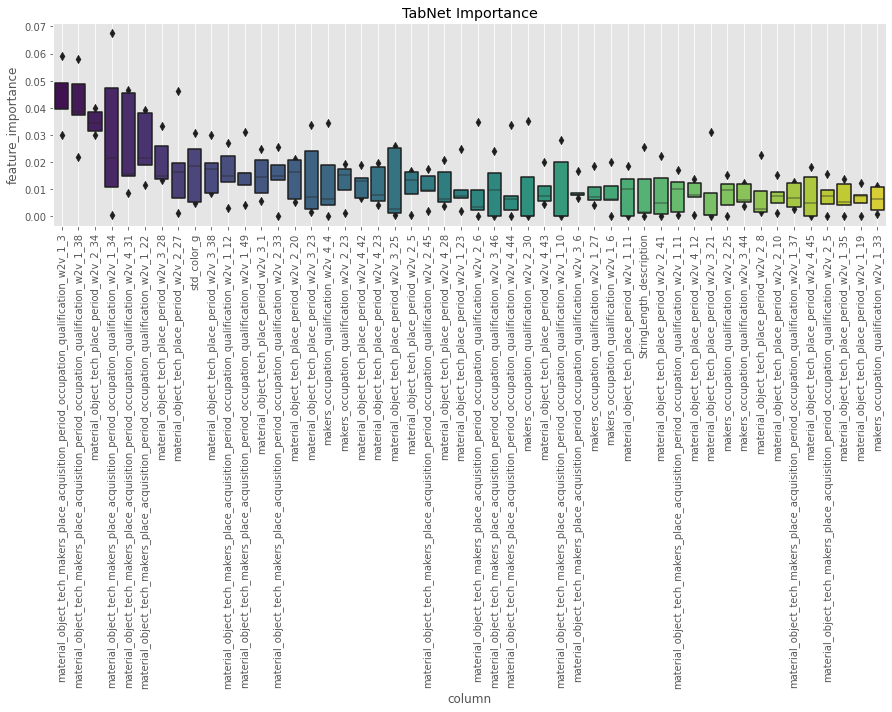

In [117]:
fig_tabnet, _ = visualize_tabnet_importance(models_tabnet, df_tabnet)

In [95]:
explain_matrix, masks = models_tabnet[0].explain(X_test)

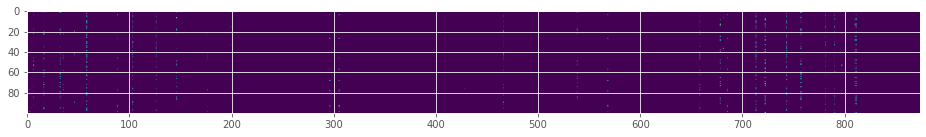

In [105]:
plt.figure(figsize=(16,100))
plt.imshow(masks[1][:100])

In [92]:
# # mask。特徴が多いと意味が分からない
mask_tabnet = visualize_mask(models_tabnet, df_tabnet)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2a6b27b950> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2a6b283440> (for post_execute):


KeyboardInterrupt: ignored

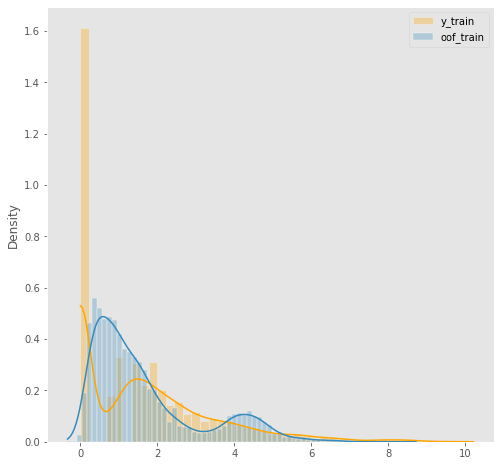

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(y_train, label='y_train', kde=True ,stat="density", common_norm=False, color='orange', alpha=0.3)
sns.histplot(oof_tabnet, label='oof_train', kde=True, stat="density", common_norm=False, alpha=0.3)
ax.legend()
ax.grid()

# Submission

In [ ]:
# oof出力
pd.DataFrame({'oof_tabnet': oof_tabnet}).to_csv(f'../output/{NOTEBOOK_NAME}_oof.csv', index=False)

# submission出力
sub = pd.read_csv(os.path.join(DATA_DIR, 'atmacup10__sample_submission.csv'))
sub['likes'] = np.expm1(pred_tabnet)
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(f'../output/{NOTEBOOK_NAME}_sub.csv',index=False)